# Final Project (Group 7)

## Aim of the Project
The main aim of this notebook is to pick a corpus of text (Sherlock Holmes) to analyse, model, and summarize. Here we have implemented basic computational model (Negative Binomial Model), network model (Text Summarization using TextRank), and semantic model (K-Medoids). After that we have done a bit research to extend them and extract a maximum amount of information from corpus.

### Import Libraries

In [4]:
%matplotlib inline
import os
import re
import string
import nltk
import random
import numpy as np
import pymc3 as pm 
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy import optimize
from pymc3.glm import GLM
from tqdm import tqdm

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# 1. Negative Binomial Model


In [5]:
mao_paragraphs = []
for root, dirs, files in os.walk("SH"):
    for file in files:
        if file.endswith(".txt"):
            with open(os.path.join(root, file), errors="ignore") as input:
                paragraphs = input.read().split("\n\n")   #\n\n denotes there is a blank line in between paragraphs.
            #print(paragraphs[0])
            mao_paragraphs.extend(paragraphs)
            
print(len(mao_paragraphs))
print(mao_paragraphs[0])

49
y dear fellow,â€ said Sherlock Holmes as we sat on either side of the fire in his lodgings at Baker Street, â€œlife is infinitely stranger than anything which the mind of man could invent. We would not dare to conceive the things which are really mere commonplaces of existence. If we could fly out of that window hand in hand, hover over this great city, gently remove the roofs, and peep in at the queer things which are 
going on, the strange coincidences, the plannings, the crosspurposes, the wonderful chains of events, working through generations, and leading to the most outre Ì results, it would make all fiction with its conventionalities and foreseen conclusions most stale and unprofitable.â€ 
â€œAnd yet I am not convinced of it,â€ I answered. â€œThe cases which come to light in the papers are, as a rule, bald enough, and vulgar enough. We have in our police reports realism pushed to its extreme 
limits, and yet the result is, it must be confessed, neither fascinating nor artisti

In [6]:
import os
mao_sentences = []
for root, dirs, files in os.walk("SH"):
    for file in files:
        if file.endswith(".txt"):
            with open(os.path.join(root, file), errors="ignore") as input:
                sentences = input.read().split(". ")   #. denotes end of sentence
            mao_sentences.extend(sentences)
            
print(len(mao_sentences))
print(mao_sentences[0])

3524
y dear fellow,â€ said Sherlock Holmes as we sat on either side of the fire in his lodgings at Baker Street, â€œlife is infinitely stranger than anything which the mind of man could invent


In [7]:
moral_words = []
for root, dirs, files in os.walk("SH"):
    for file in files:
        if file.endswith(".txt"):
            with open(os.path.join(root, file), errors="ignore") as input:
                pair_lines = input.read().split("\n")
            for p in pair_lines:
                moral_words.append(p.split('\t')[0])
print(moral_words[0:10])

['y dear fellow,â€ said Sherlock Holmes as we sat on either side of the fire in his lodgings at Baker Street, â€œlife is infinitely stranger than anything which the mind of man could invent. We would not dare to conceive the things which are really mere commonplaces of existence. If we could fly out of that window hand in hand, hover over this great city, gently remove the roofs, and peep in at the queer things which are ', 'going on, the strange coincidences, the plannings, the crosspurposes, the wonderful chains of events, working through generations, and leading to the most outre Ì results, it would make all fiction with its conventionalities and foreseen conclusions most stale and unprofitable.â€ ', 'â€œAnd yet I am not convinced of it,â€ I answered. â€œThe cases which come to light in the papers are, as a rule, bald enough, and vulgar enough. We have in our police reports realism pushed to its extreme ', 'limits, and yet the result is, it must be confessed, neither fascinating nor

In [8]:
import pandas as pd
mao_df = pd.DataFrame(mao_sentences, columns = ['Sentence'])
mao_df.head()

Sentence
0  y dear fellow,â€ said Sherlock Holmes as we sa...
1  We would not dare to conceive the things which...
2  If we could fly out of that window hand in han...
3  â€œThe cases which come to light in the papers...
4  We have in our police reports realism pushed t...

In [9]:
import re
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
    normalized_texts = ''
    lower = texts.lower()
    no_punctuation = NON_ALPHANUM.sub(r' ', lower)
    no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
    return no_non_ascii
  
mao_df['Sentence2'] = mao_df['Sentence'].apply(normalize_texts)
mao_df.head()
mao_df['Sentence2'] = mao_df['Sentence2'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

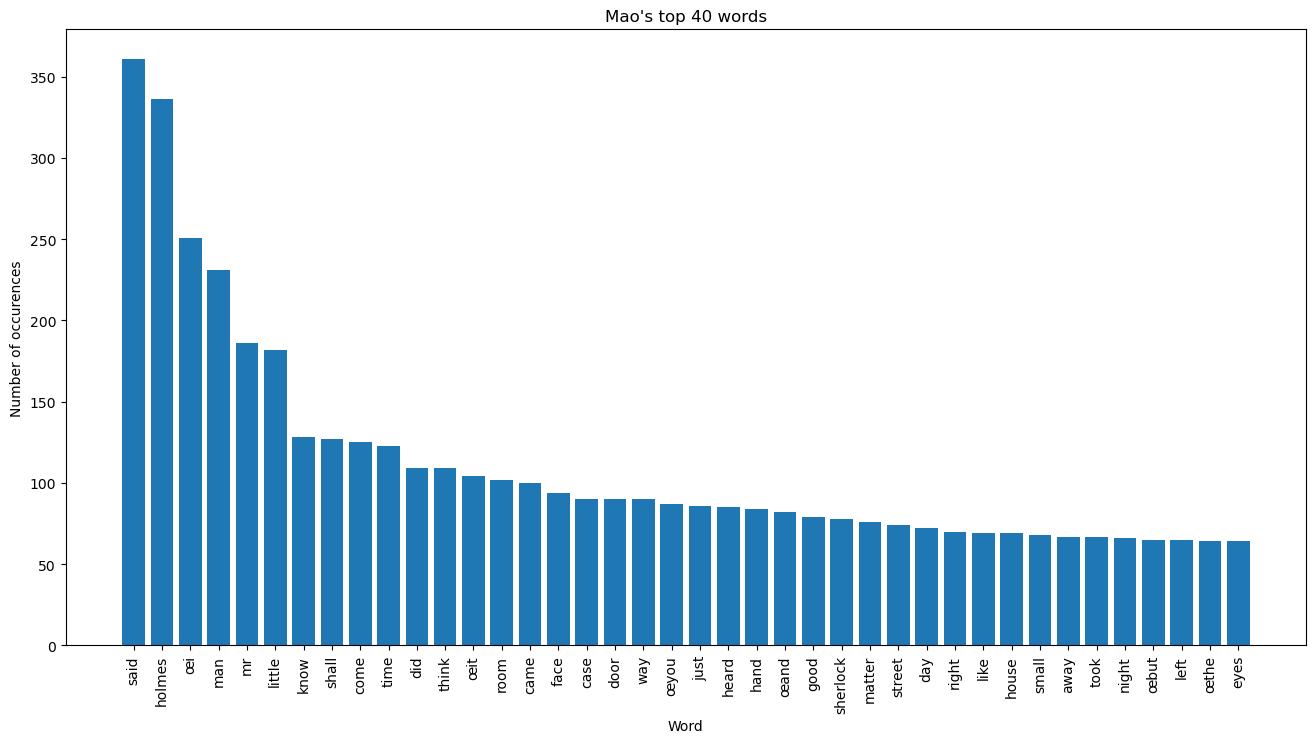

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def get_top_n_words(corpus, n=10):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

words = []
word_values = []
for i,j in get_top_n_words(mao_df['Sentence'], 40):
    words.append(i)
    word_values.append(j)
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title("Mao's top 40 words");
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

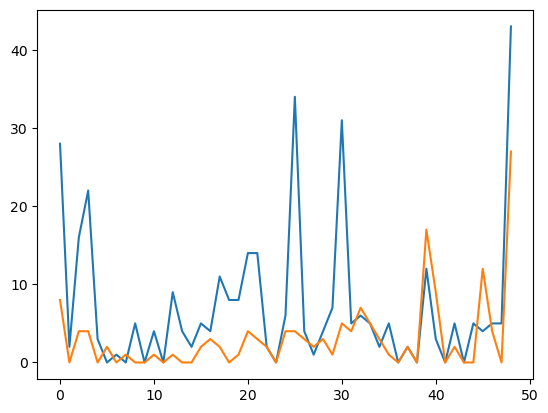

In [61]:
from collections import Counter, defaultdict

def get_words_paragraphs(paragraphs, words):
    
    word_para = defaultdict(list)
    for p in mao_paragraphs:
        for w in words:
            word_para[w].append(p.count(w))
            
    return dict(word_para)

sherlock_holmes_occurences = get_words_paragraphs(mao_paragraphs, ['Holmes', 'Sherlock'])
holmes_occurences = [v for k,v in sherlock_holmes_occurences.items() if k == 'Holmes'][0]
sherlock_occurences = [v for k,v in sherlock_holmes_occurences.items() if k == 'Sherlock'][0]
plt.plot(holmes_occurences)
plt.plot(sherlock_occurences)

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 39.46it/s]


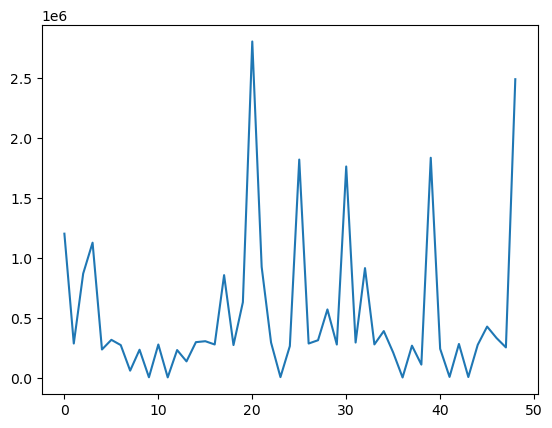

In [62]:
def get_any_words_paragraphs(paragraphs, words):
    
    word_para = []
    for p in tqdm(paragraphs):
        total = 0
        for w in words:
            total += p.count(w)
        word_para.append(total)
            
    return word_para

moral_occurences = get_any_words_paragraphs(mao_paragraphs, moral_words)
plt.plot(moral_occurences)

In [64]:
bool_holmes_occurences = [bool(v) for v in holmes_occurences]
bool_sherlock_occurences = [bool(v) for v in sherlock_occurences]
df_moral = pd.DataFrame(list(zip(moral_occurences, gentry_occurences, peasant_occurences)), 
                        columns =['morals', 'holmes', 'sherlock'])

In [47]:
def plot_traces(trcs, varnames=None):
    '''Plot traces with overlaid means and values'''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.summary(trcs,varnames).iterrows()})

    for i, mn in enumerate(pm.summary(trcs, varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')

def strip_derived_rvs(rvs):
    '''Remove PyMC3-generated RVs from a list'''

    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

In [65]:
fml = 'morals ~ sherlock + holmes + sherlock:holmes'

with pm.Model() as model:
    pm.glm.GLM.from_formula(formula=fml, data=df_moral, family=pm.glm.families.NegativeBinomial())
    trace = pm.sample(4000, cores=2)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
C:\Users\Urmip\AppData\Local\Temp\ipykernel_32360\2376395191.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(4000, cores=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Urmip\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Urmip\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, mu, sherlock:holmes, holmes, sherlock, Intercept]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 1921 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [66]:
rvs = [rv.name for rv in strip_derived_rvs(model.unobserved_RVs)]
rvs

['Intercept', 'sherlock', 'holmes', 'sherlock:holmes', 'mu', 'alpha']

C:\Users\Urmip\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\Urmip\AppData\Local\Temp\ipykernel_32360\3527538150.py:8: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  ax = pm.traceplot(trcs, varnames, figsize=(12,nrows*1.4),
C:\Users\Urmip\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\Urmip\anaconda3\lib\site-packages\arviz\plo

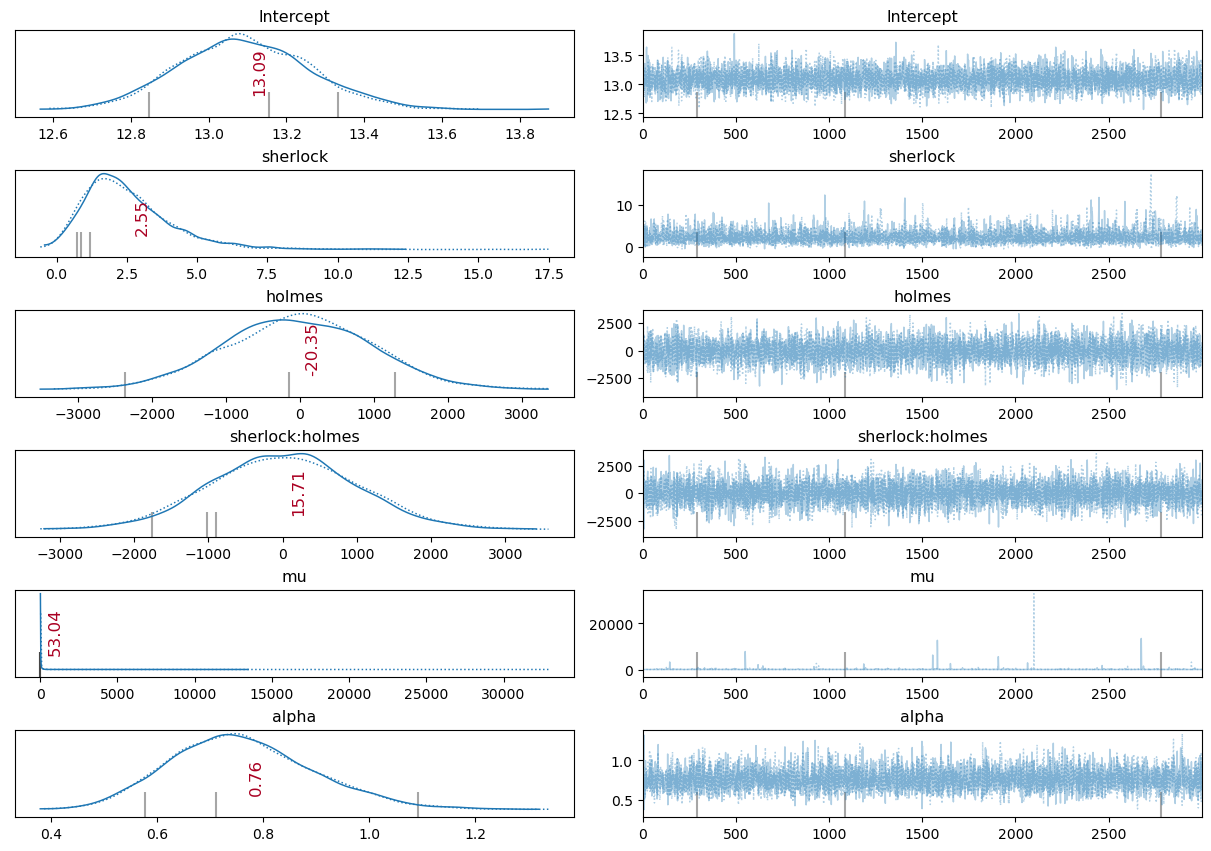

In [67]:
plot_traces(trace[1000:], rvs)

In [68]:
np.exp(pm.summary(trace[1000:], rvs))

C:\Users\Urmip\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\Urmip\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


mean             sd         hdi_3%       hdi_97%  \
Intercept        4.855318e+05   1.181754e+00  353274.268915  6.593436e+05   
sherlock         1.276874e+01   5.186194e+00       1.093081  2.629595e+02   
holmes           1.449568e-09            inf       0.000000           inf   
sherlock:holmes  6.669130e+06            inf       0.000000           inf   
mu               1.082792e+23  5.425267e+246       1.002002  1.250872e+43   
alpha            2.138276e+00   1.143393e+00       1.695538  2.778747e+00   

                     mcse_mean        mcse_sd  ess_bulk  ess_tail     r_hat  
Intercept             1.002002       1.002002       inf       inf  2.718282  
sherlock              1.033551       1.028396       inf       inf  2.718282  
holmes           703624.421081  873269.942927       inf       inf  2.718282  
sherlock:holmes  202804.958379  259626.671684       inf       inf  2.718282  
mu                 7950.578720     573.065488       inf       inf  2.718282  
alpha                 1.002002       1.001001       inf       inf  2.718282

In [172]:
df_moral2 = pd.DataFrame(list(zip(moral_occurences, bool_sherlock_occurences, bool_holmes_occurences)), 
                        columns =['morals', 'sherlock_p', 'holmes_p'])


C:\Users\Urmip\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


[Text(0, 0, '0'),
 Text(5, 0, '5'),
 Text(10, 0, '10'),
 Text(15, 0, '15'),
 Text(20, 0, '20'),
 Text(25, 0, '25'),
 Text(30, 0, '30'),
 Text(35, 0, '35'),
 Text(40, 0, '40'),
 Text(45, 0, '45')]

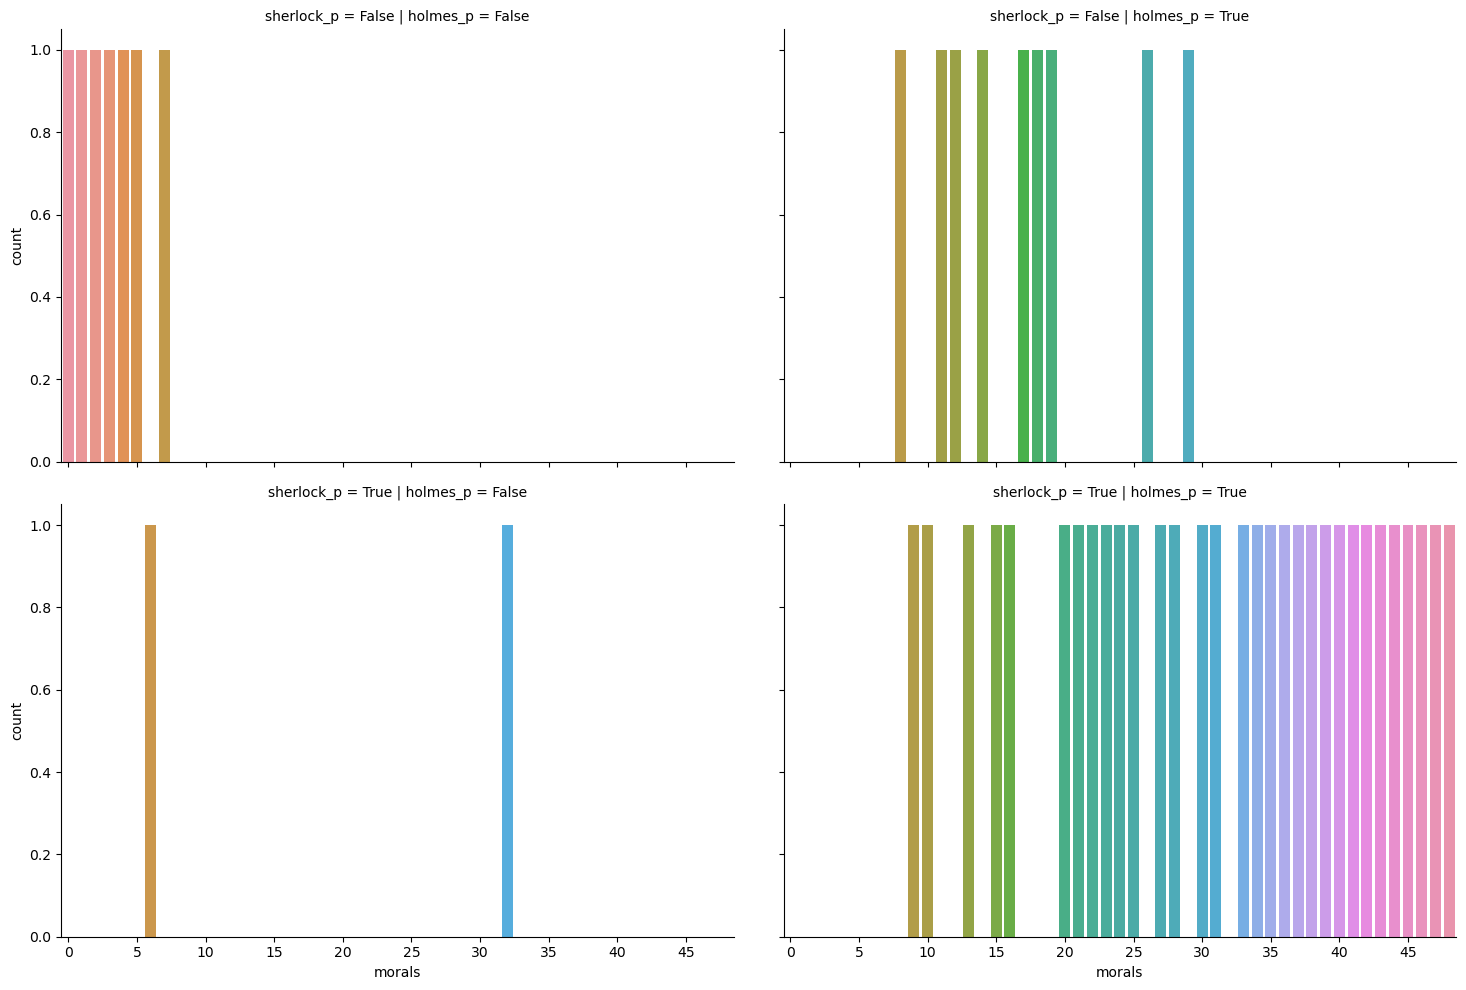

In [70]:
g = sns.factorplot(x='morals', row='sherlock_p', col='holmes_p', data=df_moral2, kind='count', aspect=1.5)

# Make x-axis ticklabels less crowded
ax = g.axes[1, 0]
labels = range(len(ax.get_xticklabels(which='both')))
ax.set_xticks(labels[::5])
ax.set_xticklabels(labels[::5])

In [71]:
df_moral2.groupby(['sherlock_p', 'holmes_p'])['morals'].agg(['mean', 'var'])

mean           var
sherlock_p holmes_p                             
False      False      18955.428571  1.581263e+09
           True      250430.111111  2.297463e+09
True       False     186991.500000  3.302887e+10
           True      742478.806452  4.963046e+11

In [72]:
fml = 'morals ~ sherlock_p + holmes_p + sherlock_p:holmes_p'

with pm.Model() as model:
    pm.glm.GLM.from_formula(formula=fml, data=df_moral2, family=pm.glm.families.NegativeBinomial())
    trace = pm.sample(2000, cores=2)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
C:\Users\Urmip\AppData\Local\Temp\ipykernel_32360\1754026594.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, cores=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Urmip\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Urmip\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, mu, sherlock_p[T.True]:holmes_p[T.True], holmes_p[T.True], s

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1495 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


['Intercept', 'sherlock_p[T.True]', 'holmes_p[T.True]', 'sherlock_p[T.True]:holmes_p[T.True]', 'mu', 'alpha']


C:\Users\Urmip\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\Urmip\AppData\Local\Temp\ipykernel_32360\3527538150.py:8: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  ax = pm.traceplot(trcs, varnames, figsize=(12,nrows*1.4),
C:\Users\Urmip\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\Urmip\anaconda3\lib\site-packages\arviz\plo

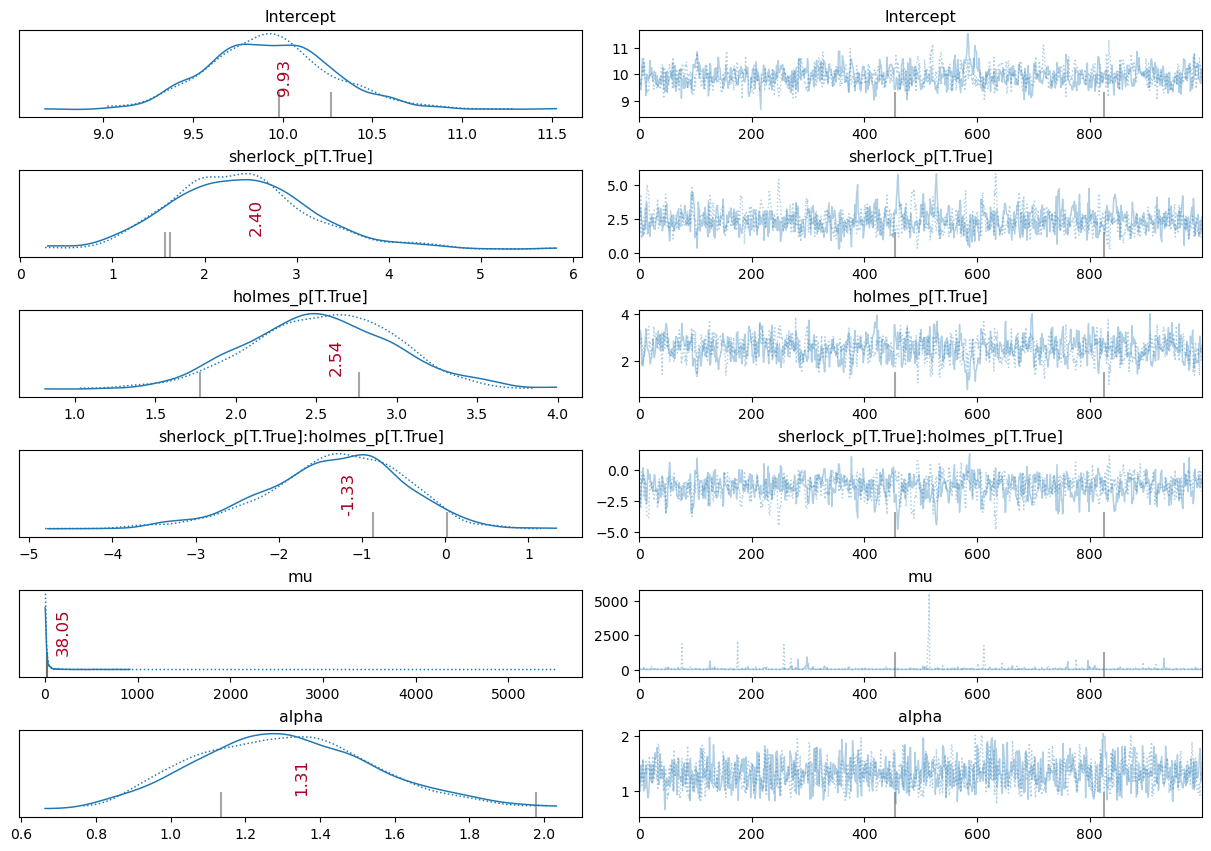

In [73]:
rvs = [rv.name for rv in strip_derived_rvs(model.unobserved_RVs)]
print(rvs)
plot_traces(trace[1000:], rvs)

In [74]:
np.exp(pm.summary(trace[500:], rvs)[['mean','hdi_3%','hdi_97%']])

C:\Users\Urmip\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean        hdi_3%       hdi_97%
Intercept                            2.033299e+04  10927.086656  3.977524e+04
sherlock_p[T.True]                   1.151902e+01      2.552313  5.448906e+01
holmes_p[T.True]                     1.288418e+01      5.651947  3.236249e+01
sherlock_p[T.True]:holmes_p[T.True]  2.498237e-01      0.043153  1.160673e+00
mu                                   3.160210e+16      1.010050  3.994191e+43
alpha                                3.717309e+00      2.394082  5.680277e+00

In [75]:
trace[1000:]['Intercept'].mean()

9.93054667311751

In [76]:
trace[1000:]['holmes_p[T.True]'].mean()

2.53712405509214

# 2. Text Summarization using TextRank


As a Text corpus, I have taken Some Sherlock Holmes Stories by Arthur Conan Doyle

In [147]:
for root, dirs, files in os.walk("SH"):
    for file in files:
        if file.endswith(".txt"):
             print(os.path.join(root, file))

SH\A Case of Identity.txt
SH\A_Scandal_in_Bohemia.txt
SH\The Adventure of the Blue Carbuncle.txt
SH\The Adventure of the EngineerΓÇÖs Thumb .txt
SH\The Adventure of the Speckled Band.txt
SH\The Boscombe Valley Mystery.txt
SH\The Five Orange Pips.txt
SH\The Man with the Twisted Lip.txt
SH\The-Red-Headed-League.txt


In [79]:
new_paragraphs = []
for root, dirs, files in os.walk("SH"):
    for file in files:
        if file.endswith(".txt"):
            print(os.path.join(root, file))
            with open(os.path.join(root, file),  errors="ignore") as input:
                paragraphs = input.read().split("\n\n")   #\n\n denotes there is a blank line in between paragraphs.
            #print(paragraphs[0])
            new_paragraphs.extend(paragraphs)
            
print(len(new_paragraphs))
print(new_paragraphs[0])

SH\A Case of Identity.txt
SH\A_Scandal_in_Bohemia.txt
SH\The Adventure of the Blue Carbuncle.txt
SH\The Adventure of the EngineerΓÇÖs Thumb .txt
SH\The Adventure of the Speckled Band.txt
SH\The Boscombe Valley Mystery.txt
SH\The Five Orange Pips.txt
SH\The Man with the Twisted Lip.txt
SH\The-Red-Headed-League.txt
49
y dear fellow,â€ said Sherlock Holmes as we sat on either side of the fire in his lodgings at Baker Street, â€œlife is infinitely stranger than anything which the mind of man could invent. We would not dare to conceive the things which are really mere commonplaces of existence. If we could fly out of that window hand in hand, hover over this great city, gently remove the roofs, and peep in at the queer things which are 
going on, the strange coincidences, the plannings, the crosspurposes, the wonderful chains of events, working through generations, and leading to the most outre Ì results, it would make all fiction with its conventionalities and foreseen conclusions most sta

In [80]:
new_sentences = []
for root, dirs, files in os.walk("SH"):
    for file in files:
        if file.endswith(".txt"):
            print(os.path.join(root, file))
            with open(os.path.join(root, file), errors="ignore") as input:
                sentences = input.read().split(". ")   #. denotes end of sentence
            new_sentences.extend(sentences)
            
print(len(new_sentences))
print(new_sentences[0])

SH\A Case of Identity.txt
SH\A_Scandal_in_Bohemia.txt
SH\The Adventure of the Blue Carbuncle.txt
SH\The Adventure of the EngineerΓÇÖs Thumb .txt
SH\The Adventure of the Speckled Band.txt
SH\The Boscombe Valley Mystery.txt
SH\The Five Orange Pips.txt
SH\The Man with the Twisted Lip.txt
SH\The-Red-Headed-League.txt
3524
y dear fellow,â€ said Sherlock Holmes as we sat on either side of the fire in his lodgings at Baker Street, â€œlife is infinitely stranger than anything which the mind of man could invent


In [81]:
new_df = pd.DataFrame(new_sentences, columns = ['Sentence'])
new_df.head()

Sentence
0  y dear fellow,â€ said Sherlock Holmes as we sa...
1  We would not dare to conceive the things which...
2  If we could fly out of that window hand in han...
3  â€œThe cases which come to light in the papers...
4  We have in our police reports realism pushed t...

Now, Lets clean our sentences

In [82]:
def eda(sentences):
    processed_sentences = []

    for s in sentences:
        # Remove all the special characters
        processed_sentence = re.sub(r'\W', ' ', str(s))

        # remove all single characters
        processed_sentence= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_sentence)

        # Remove single characters from the start
        processed_sentence = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_sentence) 

        # Substituting multiple spaces with single space
        processed_sentence = re.sub(r'\s+', ' ', processed_sentence, flags=re.I)

        # Removing prefixed 'b'
        processed_sentence = re.sub(r'^b\s+', '', processed_sentence)

        # Converting to Lowercase
        processed_sentence = processed_sentence.lower()

        processed_sentences.append(processed_sentence)
        
    return processed_sentences

In [83]:
processed_sentences = eda(new_sentences)

In [84]:
len(processed_sentences)

3524

In [85]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Urmip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [86]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer (max_features=2500, min_df=1, max_df=0.8, stop_words=stopwords.words('english'))
processed_sentences_vectors = vectorizer.fit_transform(processed_sentences).toarray()

In [87]:
processed_sentences_vectors.shape

(3524, 2500)

In [90]:
from sentence_transformers import SentenceTransformer

In [91]:
#model = SentenceTransformer('stsb-roberta-large') #1,024 dims
#model2 = SentenceTransformer('bert-base-nli-mean-tokens') #768 dims
bmodel = SentenceTransformer('all-MiniLM-L6-v2') #384 dims

In [92]:
bert_embeddings = bmodel.encode(new_sentences)
bert_embeddings.shape

(3524, 384)

In [93]:
#Print the embeddings
for i, (sentence, embedding) in enumerate(zip(processed_sentences, bert_embeddings)):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")
    if i == 3: break

Sentence: y dear fellow â said sherlock holmes as we sat on either side of the fire in his lodgings at baker street â œlife is infinitely stranger than anything which the mind of man could invent
Embedding: [-3.44637744e-02  1.34922424e-02 -2.77498495e-02 -8.65249988e-03
  1.98662048e-03 -1.51448436e-02  9.56387073e-02 -1.67112984e-02
 -6.30063042e-02 -5.67753725e-02 -1.21784946e-02  1.64967924e-02
  5.41902892e-02  3.29145715e-02 -2.51969993e-02 -2.05747876e-02
 -2.85112616e-02 -3.49897705e-02  1.58762056e-02  2.58781761e-02
 -1.98809579e-02 -6.32977160e-03  4.27584723e-02 -3.65593396e-02
 -7.79988095e-02  2.10784804e-02  8.70054066e-02 -4.02827412e-02
 -5.00780493e-02  2.71135829e-02  3.76202166e-02  3.46047170e-02
 -1.44332275e-02 -5.61594889e-02  4.77398373e-02 -6.47287890e-02
  4.58828285e-02  8.42606723e-02  8.84215385e-02 -4.02536839e-02
 -7.42835850e-02 -6.78594634e-02 -1.85800698e-02  8.89981911e-02
 -6.67367280e-02 -1.48711866e-02  6.92242524e-03 -8.51711854e-02
  9.73041635e

In [94]:
a = bert_embeddings[0]
b = bert_embeddings[1]
cos_sim = (a @ b.T) / (np.linalg.norm(a)*np.linalg.norm(b))
cos_sim

0.38002294

In [95]:
bert_embeddings.shape

(3524, 384)

In [148]:
M = np.eye(200)

for i,a in tqdm(enumerate(bert_embeddings)):
    for j,b in enumerate(bert_embeddings):
        if i != j:
            M[i,j] = (a @ b.T) / (np.linalg.norm(a)*np.linalg.norm(b))

0it [00:00, ?it/s]


IndexError: index 200 is out of bounds for axis 1 with size 200

In [97]:
import networkx

similarity_graph = networkx.from_numpy_array(M)
similarity_graph

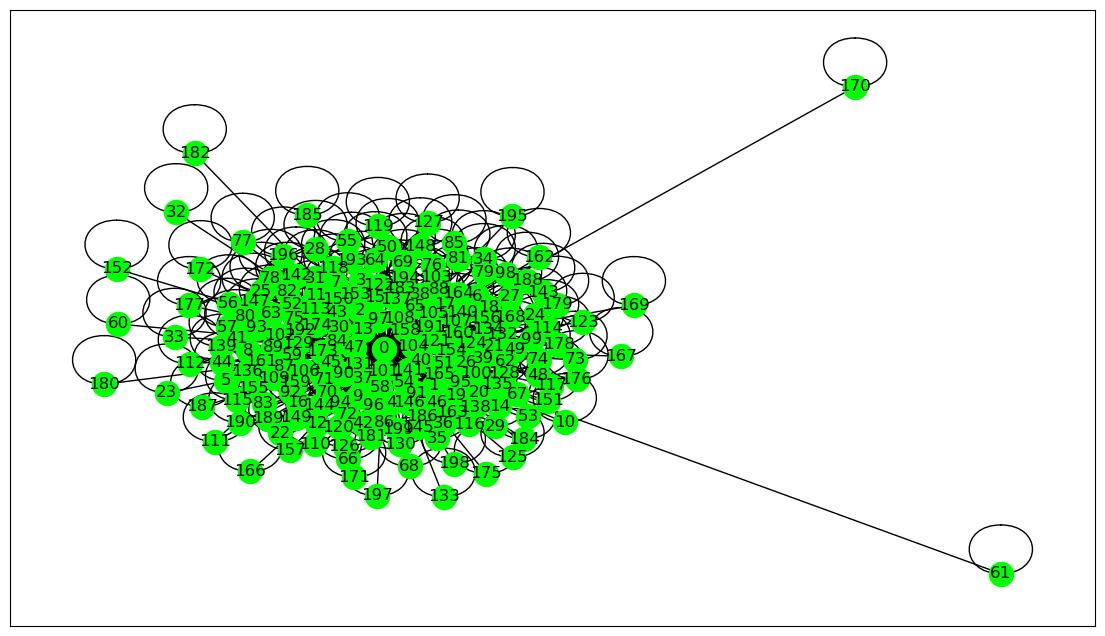

In [98]:
plt.figure(figsize=(14, 8))
networkx.draw_networkx(similarity_graph, node_color='lime')

In [99]:
scores = networkx.pagerank(similarity_graph)
nx_ranked_sentences = sorted(((score, index) for index, score 
                                            in scores.items()), 
                          reverse=True)
nx_ranked_sentences[:10]

[(0.13992487706955206, 0),
 (0.005337413717504744, 61),
 (0.0049537937132088415, 170),
 (0.004799897259328686, 182),
 (0.0047801903036227235, 104),
 (0.004673032648380068, 32),
 (0.004666573699593891, 47),
 (0.004638052266062607, 152),
 (0.004636122085470446, 101),
 (0.004625649820378724, 84)]

In [100]:
processed_sentences[135]

'your own opinion is then that some unforeseen catastrophe has oc curred to him â â œyes sir'

In [101]:
processed_sentences[178]

'my first glance is always at womanâ sleeve'

In [102]:
for i in range(10):
    print(processed_sentences[nx_ranked_sentences[i][1]])
    print('----------')

y dear fellow â said sherlock holmes as we sat on either side of the fire in his lodgings at baker street â œlife is infinitely stranger than anything which the mind of man could invent
----------
it is in new zealand stock paying 41 2 per cent
----------
her dress was brown rather darker than coffee colour with little purple plush at the neck and sleeves
----------
the sewingmachine of the hand type leaves similar mark but only on the left arm and on the side of it farthest from the thumb instead of being right across the broadest part as this was
----------
holmes and the little things that he would think of â â œit was most suggestive â said holmes
----------
she would like advice but is not sure that the matter is not too delicate for communication
----------
hosmer angel â â œwhy did you come away to consult me in such hurry â asked sherlock holmes with his finger tips together and his eyes to the ceiling
----------
you will leave the papers here and remember the advice which have

# Extension -- Generating Story using Markov Chain Model

Reading Every Sherlock Holmes Story

In [138]:
story_path = "sherlock/"

def read_all_stories(story_path):
    txt = []
    for _, _, files in os.walk(story_path):
        for file in files:
            with open(story_path+file) as f:
                for line in f:
                    line = line.strip()
                    if line=='----------': break
                    if line!='':txt.append(line)
    return txt
        
stories = read_all_stories(story_path)
print("number of lines = ", len(stories))

number of lines =  215021


Cleaning the Text and Converting all text into words

In [139]:
def clean_txt(txt):
    cleaned_txt = []
    for line in txt:
        line = line.lower()
        line = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-\\]", "", line)
        tokens = word_tokenize(line)
        words = [word for word in tokens if word.isalpha()]
        cleaned_txt+=words
    return cleaned_txt

cleaned_stories = clean_txt(stories)
print("number of words = ", len(cleaned_stories))

number of words =  2332110


Here I have used a custom Markov Model

In [140]:
def make_markov_model(cleaned_stories, n_gram=2):
    markov_model = {}
    for i in range(len(cleaned_stories)-n_gram-1):
        curr_state, next_state = "", ""
        for j in range(n_gram):
            curr_state += cleaned_stories[i+j] + " "
            next_state += cleaned_stories[i+j+n_gram] + " "
        curr_state = curr_state[:-1]
        next_state = next_state[:-1]
        if curr_state not in markov_model:
            markov_model[curr_state] = {}
            markov_model[curr_state][next_state] = 1
        else:
            if next_state in markov_model[curr_state]:
                markov_model[curr_state][next_state] += 1
            else:
                markov_model[curr_state][next_state] = 1
    
    # calculating transition probabilities
    for curr_state, transition in markov_model.items():
        total = sum(transition.values())
        for state, count in transition.items():
            markov_model[curr_state][state] = count/total
        
    return markov_model

In [141]:
markov_model = make_markov_model(cleaned_stories)

In [142]:
print("number of states = ", len(markov_model.keys()))

number of states =  208670


In [143]:
markov_model.keys()

dict_keys(['the adventure', 'adventure of', 'of the', 'the three', 'three gables', 'gables arthur', 'arthur conan', 'conan doyle', 'doyle i', 'i dont', 'dont think', 'think that', 'that any', 'any of', 'of my', 'my adventures', 'adventures with', 'with mr', 'mr sherlock', 'sherlock holmes', 'holmes opened', 'opened quite', 'quite so', 'so abruptly', 'abruptly or', 'or so', 'so dramatically', 'dramatically as', 'as that', 'that which', 'which i', 'i associate', 'associate with', 'with the', 'gables i', 'i had', 'had not', 'not seen', 'seen holmes', 'holmes for', 'for some', 'some days', 'days and', 'and had', 'had no', 'no idea', 'idea of', 'the new', 'new channel', 'channel into', 'into which', 'which his', 'his activities', 'activities had', 'had been', 'been directed', 'directed he', 'he was', 'was in', 'in a', 'a chatty', 'chatty mood', 'mood that', 'that morning', 'morning however', 'however and', 'had just', 'just settled', 'settled me', 'me into', 'into the', 'the low', 'low armc

In [144]:
print("All possible transitions from 'the game' state: \n")
print(markov_model['the game'])

All possible transitions from 'the game' state: 

{'your letter': 0.02702702702702703, 'was up': 0.09009009009009009, 'is afoot': 0.036036036036036036, 'for the': 0.036036036036036036, 'was in': 0.02702702702702703, 'is hardly': 0.02702702702702703, 'would have': 0.036036036036036036, 'is up': 0.06306306306306306, 'is and': 0.036036036036036036, 'in their': 0.036036036036036036, 'was whist': 0.036036036036036036, 'in that': 0.036036036036036036, 'the lack': 0.036036036036036036, 'for all': 0.06306306306306306, 'may wander': 0.02702702702702703, 'now a': 0.02702702702702703, 'my own': 0.02702702702702703, 'at any': 0.02702702702702703, 'mr holmes': 0.02702702702702703, 'ay whats': 0.02702702702702703, 'my friend': 0.02702702702702703, 'fairly by': 0.02702702702702703, 'is not': 0.02702702702702703, 'was not': 0.02702702702702703, 'was afoot': 0.036036036036036036, 'worth it': 0.02702702702702703, 'you are': 0.02702702702702703, 'i am': 0.02702702702702703, 'now count': 0.027027027027027

Creating a custom function to generate story

In [145]:
def generate_story(markov_model, limit=100, start='my god'):
    n = 0
    curr_state = start
    next_state = None
    story = ""
    story+=curr_state+" "
    while n<limit:
        next_state = random.choices(list(markov_model[curr_state].keys()),
                                    list(markov_model[curr_state].values()))
        
        curr_state = next_state[0]
        story+=curr_state+" "
        n+=1
    return story

In [146]:
for i in range(10):
    print(str(i)+". ", generate_story(markov_model, start="dear mr", limit=8))

0.  dear mr mac is one of the a maze of fantastic tracery in wrought iron with pillars on 
1.  dear mr sherlock holmes was wrong young charpentier could not get help from outside even if we can 
2.  dear mr holmes in his didactic fashion lay in the morning post to say that a path has 
3.  dear mr holmes i invite your attention to the south american line when that was taken by the 
4.  dear mr holmes he had bounded across the room and handing my friend the vicar sprang from it 
5.  dear mr sherlock holmes you have seen pictures and read for myself these are my last hope if 
6.  dear mr sherlock holmes would at first sight presented a more singular features than that which belonged to 
7.  dear mr grant munro to the task of placing upon record that severe reasoning from cause to effect 
8.  dear mr sherlock holmes laughed heartily at my wits end very naturally mr ferguson only told me this 
9.  dear mr sherlock holmes the theorist remember you ill never get the number my dear watson said

# 3. "K-Medoids for Semantic Model"

In [114]:
from sklearn.datasets import load_digits
digits = load_digits()
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

In [115]:
digits.data.shape

(1797, 64)

In [116]:
num_digits = len(np.unique(digits.target))
num_digits

10

In [117]:
np.std(bert_embeddings[0])

0.050972737

In [118]:
#Standardize the data

bert_embeddings_std = scale(bert_embeddings)

C:\Users\Urmip\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
C:\Users\Urmip\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


In [119]:
#Performing dimensionality reduction where no. of newly formed components=2

bert_embeddings_red = PCA(n_components=2).fit_transform(bert_embeddings_std)

In [120]:
# Plot the decision boundaries for each cluster. Assign a different color to each for differentiation.

h = 0.02 #step size of the mesh 
#Minimum and maximum x-coordinates
xmin, xmax = bert_embeddings_red[:, 0].min() - 1, bert_embeddings_red[:, 0].max() + 1
#Minimum and maximum y-coordinates
ymin, ymax = bert_embeddings_red[:, 1].min() - 1, bert_embeddings_red[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))

In [121]:
# PAM (Partition Around Medoids) algorithm for finding the medoids.
#No. of clusters= 10
models = [
     (
         KMedoids(metric="manhattan", n_clusters=num_digits, 
         init="heuristic", max_iter=2),"Manhattan metric",
     ),
     (
         KMedoids(metric="euclidean", n_clusters=num_digits,  
         init="heuristic", max_iter=2),"Euclidean metric",
     ),
     (KMedoids(metric="cosine", n_clusters=num_digits, init="heuristic", 
      max_iter=2), "Cosine metric", ),
 ]
models

[(KMedoids(max_iter=2, metric='manhattan', n_clusters=10), 'Manhattan metric'),
 (KMedoids(max_iter=2, n_clusters=10), 'Euclidean metric'),
 (KMedoids(max_iter=2, metric='cosine', n_clusters=10), 'Cosine metric')]

In [122]:
##Initializing the number of rows and columns of the plot for plotting subplots of each of the three metrics’ results.

#number of rows = integer(ceiling(number of model variants/2))
num_rows = int(np.ceil(len(models) / 2.0))
#number of columns
num_cols = 2 

In [123]:
##plotting the resultant clustering

#Clear the current figure first (if any)
plt.clf()

#Initialize dimensions of the plot
plt.figure(figsize=(15,10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

C:\Users\Urmip\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:243: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Urmip\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:243: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Urmip\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:243: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


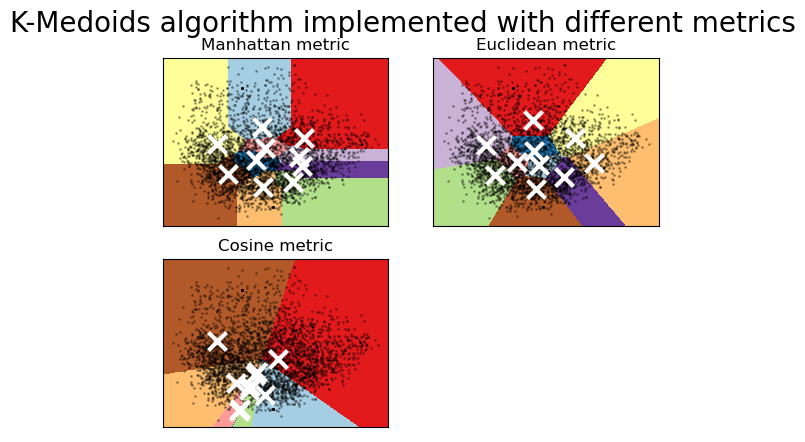

In [124]:
##fitting the data to the model and plotting the results.

for i, (model, description) in enumerate(models):
    # Fit each point in the mesh to the model
    model.fit(bert_embeddings_red)
    
    #Predict the labels for points in the mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result  into a color plot
    Z = Z.reshape(xx.shape)
   
    #Subplot for the ith model variant
    plt.subplot(num_cols, num_rows, i + 1)
   
    #Display the subplot
    plt.imshow(
         Z,    #data to be plotted
         interpolation="nearest",
        #bounding box coordinates (left,right,bottom,top)
         extent=(xx.min(), xx.max(), yy.min(), yy.max()),
         cmap=plt.cm.Paired,  #colormap
         aspect="auto", #aspect ratio of the axes
         origin="lower",  #set origin as lower left corner of the axes
    )
    plt.plot(
         bert_embeddings_red[:, 0], bert_embeddings_red[:, 1], "k.", markersize=2, alpha=0.3
    )
        
    # Plot the centroids as white cross marks
    centroids = model.cluster_centers_
    plt.scatter(
         centroids[:, 0],
         centroids[:, 1],
         marker="x",
         s=169,  #marker’s size (points^2)
         linewidths=3, #width of boundary lines
         color="w",  #white color for centroids markings
         zorder=10,  #drawing order of axes
    )
    
    #describing text of the tuple will be title of the subplot
    plt.title(description)  
    plt.xlim(xmin, xmax)  #limits of x-coordinates
    plt.ylim(ymin, ymax)  #limits of y-coordinates
    plt.xticks(())   
    plt.yticks(())
    
#Upper title of the whole plot
plt.suptitle(
    #Text to be displayed
    "K-Medoids algorithm implemented with different metrics\n\n",
    fontsize=20,  #size of the fonts
)
plt.show()

In [125]:
centroids

array([[ 3.2680273e-01, -4.7257481e+00],
       [-2.2748077e+00, -6.8050838e+00],
       [-5.2244133e-01, -1.6054726e+00],
       [-6.8824434e-01, -2.0258489e+00],
       [ 1.5980352e+00,  5.6305439e-03],
       [-2.5679920e+00, -3.1427524e+00],
       [-1.2096323e+00, -3.5638082e+00],
       [-1.3189721e+00, -3.9725480e+00],
       [-2.1803992e+00, -6.4847994e+00],
       [-4.5234962e+00,  2.3865666e+00]], dtype=float32)

In [126]:
##Without dimensionality reduction:

centroids = []
for i, (model, description) in enumerate(models):
    model.fit(bert_embeddings_std)
    centroids.append(model.cluster_centers_)

C:\Users\Urmip\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:243: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [127]:
##Identifying the centroid:

centroid_indeces = []

for i in range(10):
    c = centroids[2][i]
    for j in range(bert_embeddings_std.shape[0]):
        if np.allclose(c, bert_embeddings_std[j]):
            centroid_indeces.append(j)
            break

In [128]:
centroid_indeces

[1419, 690, 1508, 3482, 1544, 3018, 248, 2327, 1373, 2249]

In [129]:
for i in centroid_indeces:
    print(i, ' -------')
    print(processed_sentences[i])
    print('---------')

1419  -------
 â œthere you are â said he
---------
690  -------
 â œyou have really got it â he cried grasping sherlock holmes by either shoulder and looking eagerly into his face
---------
1508  -------
i have no one to turn toâ none save only one who cares for me and he poor fellow can be of little aid
---------
3482  -------
holmes â said mr
---------
1544  -------
a series of disgraceful brawls took place two of which ended in the policecourt until at last he became the ter ror of the village and the folks would fly at his approach for he is man of immense strength and absolutely uncontrollable in his anger
---------
3018  -------
the manâ face peeled off under the sponge like the bark from tree
---------
248  -------
â œi think of writing another little monograph some of these days on the typewriter and its rela tion to crime
---------
2327  -------
 â œgod help us â said holmes after long silence
---------
1373  -------
i clambered out upon the sill but hesitated to jump until s

# Extension to clustering, performed K-means clustering:

In [130]:
#Explore the data
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3524 entries, 0 to 3523
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  3524 non-null   object
dtypes: object(1)
memory usage: 27.7+ KB


In [131]:
##Data Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [132]:
#Change the values in the system readable format:
documents = new_df['Sentence'].values.astype("U")

In [133]:
#Remove stopwords and transform the information
vectorizer = TfidfVectorizer(stop_words='english')
features = vectorizer.fit_transform(documents)

In [134]:
#Defined K as 10 to cluster the paragraph's information
k = 10
model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
model.fit(features)

KMeans(max_iter=100, n_clusters=10, n_init=1)

In [135]:
new_df['cluster'] = model.labels_

In [136]:
new_df.head()

Sentence  cluster
0  y dear fellow,â€ said Sherlock Holmes as we sa...        8
1  We would not dare to conceive the things which...        0
2  If we could fly out of that window hand in han...        3
3  â€œThe cases which come to light in the papers...        7
4  We have in our police reports realism pushed t...        0

In [137]:
# Clusters formed below convey some useful information:

print("Cluster centroids: \n")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(k):
    print("Cluster %d:" % i)
    for j in order_centroids[i, :10]: #print out 10 feature terms of each cluster
        print (' %s' % terms[j])
    print('------------')

Cluster centroids: 

Cluster 0:
 st
 came
 œit
 matter
 hand
 point
 street
 right
 asked
 case
------------
Cluster 1:
 took
 table
 chair
 bed
 corner
 laid
 paper
 round
 small
 having
------------
Cluster 2:
 said
 œi
 œit
 quite
 œthere
 little
 tell
 œthat
 œwell
 better
------------
Cluster 3:
 œand
 did
 asked
 said
 œi
 holmes
 wish
 œyou
 think
 hand
------------
Cluster 4:
 œi
 know
 think
 little
 time
 room
 heard
 house
 door
 night
------------
Cluster 5:
 mr
 heard
 said
 œnow
 oh
 œit
 friend
 œi
 good
 œwhat
------------
Cluster 6:
 man
 œyes
 sir
 twisted
 lip
 young
 know
 old
 case
 shall
------------
Cluster 7:
 come
 shall
 time
 said
 œthen
 way
 man
 œyou
 room
 œi
------------
Cluster 8:
 holmes
 said
 sherlock
 œi
 œyou
 œit
 asked
 think
 remarked
 œthat
------------
Cluster 9:
 face
 help
 hands
 lay
 eyes
 forward
 holmes
 way
 man
 pale
------------


C:\Users\Urmip\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Conclusion 
In this notebook, you will find a detailed explanation of how text corpora can be analysed, modeled, and summarized using data science.
Here we created a model based on the most commonly used nouns in the corpus. Because the negative binomial model is more accurate than the Poisson model, we have used it.
The corpus text has been summarized into 10 sentences. There is a story generation using the Markov Chian model in this portion.
As a final step, we have performed clustering techniques on K-Medoids.